# Convolutional Neural Networks with PyTorch

"Deep Learning" is a general term that usually refers to the use of neural networks with multiple layers that synthesize the way the human brain learns and makes decisions. A convolutional neural network is a kind of neural network that extracts *features* from matrices of numeric values (often images) by convolving multiple filters over the matrix values to apply weights and identify patterns, such as edges, corners, and so on in an image. The numeric representations of these patterns are then passed to a fully-connected neural network layer to map the features to specific classes.

There are several commonly used frameworks for creating CNNs. In this notebook, we'll build a simple example CNN using PyTorch.

## Import libraries

First, let's install and import the PyTorch libraries we'll need.

In [1]:
! pip install torch==1.9.0+cpu torchvision==0.10.0+cpu torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 2.3.0+cpu


## Explore the data

In this exercise, you'll train a CNN-based classification model that can classify images of geometric shapes. Let's take a look at the classes of shape the model needs to identify.

3 classes:
['circle', 'square', 'triangle']


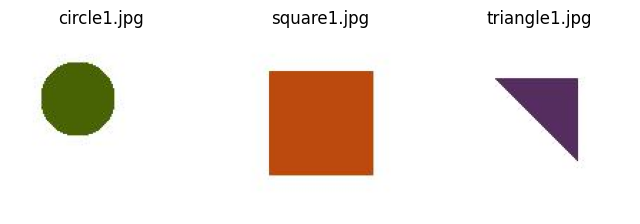

In [3]:
# The images are in the data/shapes folder
data_path = 'data/shapes/'

# Get the class names
classes = os.listdir(data_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Show the first image in each folder
fig = plt.figure(figsize=(8, 12))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)    
    
plt.show()

## Load data

PyTorch includes functions for loading and transforming data. We'll use these to create an iterative loader for training data, and a second iterative loader for test data (which we'll use to validate the trained model). The loaders will transform the image data into *tensors*, which are the core data structure used in PyTorch, and normalize them so that the pixel values are in a scale with a mean of 0.5 and a standard deviation of 0.5.

Run the following cell to define the data loaders.

In [4]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)
print('Data loaders ready')

Data loaders ready


## Define the CNN

In PyTorch, you define a neural network model as a class that is derived from the **nn.Module** base class. Your class must define the layers in your network, and provide a **forward** method that is used to process data through the layers of the network.

In [2]:
# Create a neural net class
class Net(nn.Module):
    # Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        # Our images are RGB, so input channels = 3. We'll apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # We'll apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A second convolutional layer takes 12 input channels, and generates 12 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A third convolutional layer takes 12 inputs and generates 24 outputs
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # So our feature tensors are now 32 x 32, and we've generated 24 of them
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to the probability for each class
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))
      
        # Use a relu activation function after layer 2 (convolution 2 and pool)
        x = F.relu(self.pool(self.conv2(x)))
        
        # Select some features to drop after the 3rd convolution to prevent overfitting
        x = F.relu(self.drop(self.conv3(x)))
        
        # Only drop the features if this is a training pass
        x = F.dropout(x, training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return log_softmax tensor 
        return F.log_softmax(x, dim=1)
    
print("CNN model class defined!")

NameError: name 'nn' is not defined

## Train the model

Now that we've defined a class for the network, we can train it using the image data.

Training consists of an iterative series of forward passes in which the training data is processed in batches by the layers in the network, and the optimizer goes back and adjusts the weights. We'll also use a separate set of test images to test the model at the end of each iteration (or *epoch*) so we can track the performance improvement as the training process progresses.

In the example below, we use 5 epochs to train the model using the batches of images loaded by the data loaders, holding back the data in the test data loader for validation. After each epoch, a loss function measures the error (*loss*) in the model and adjusts the weights (which were randomly generated for the first iteration) to try to improve accuracy. 

> **Note**: We're only using 5 epochs to minimize the training time for this simple example. A real-world CNN is usually trained over more epochs than this. CNN model training is processor-intensive, involving a lot of matrix and vector-based operations; so it's recommended to perform this on a system that can leverage GPUs, which are optimized for these kinds of calculation. This will take a while to complete on a CPU-based system - status will be displayed as the training progresses.

In [27]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10== 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Now use the train and test functions to train and test the model    

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 5 epochs (in a real scenario, you'd likely use many more)
epochs = 5
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
Training set [0/840 (0%)] Loss: 1.084367
trainloader : <torch.utils.data.dataloader.DataLoader object at 0x00000239F17D2E50>, train loader dataset: <torch.utils.data.dataset.Subset object at 0x00000239F17D2E90>, bathc 0
Training set [500/840 (59%)] Loss: 0.784815
trainloader : <torch.utils.data.dataloader.DataLoader object at 0x00000239F17D2E50>, train loader dataset: <torch.utils.data.dataset.Subset object at 0x00000239F17D2E90>, bathc 10
Training set: Average loss: 0.896365
Validation set: Average loss: 0.640668, Accuracy: 245/360 (68%)

Epoch: 2
Training set [0/840 (0%)] Loss: 0.461407
trainloader : <torch.utils.data.dataloader.DataLoader object at 0x00000239F17D2E50>, train loader dataset: <torch.utils.data.dataset.Subset object at 0x00000239F17D2E90>, bathc 0
Training set [500/840 (59%)] Loss: 0.421464
trainloader : <torch.utils.data.dataloader.DataLoader object at 0x00000239F17D2E50>, train loader dataset: <torch.utils.data.dataset.Subset object at 0x0000

## View the loss history

We tracked average training and validation loss for each epoch. We can plot these to verify that loss reduced as the model was trained, and to detect *over-fitting* (which is indicated by a continued drop in training loss after validation loss has levelled out or started to increase).

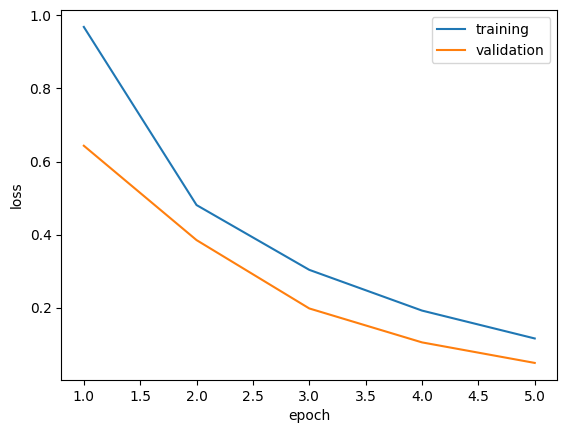

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## Evaluate model performance

You can see the final accuracy based on the test data, but typically you'll want to explore performance metrics in a little more depth. Let's plot a confusion matrix to see how well the model is predicting each class.

Getting predictions from test set...


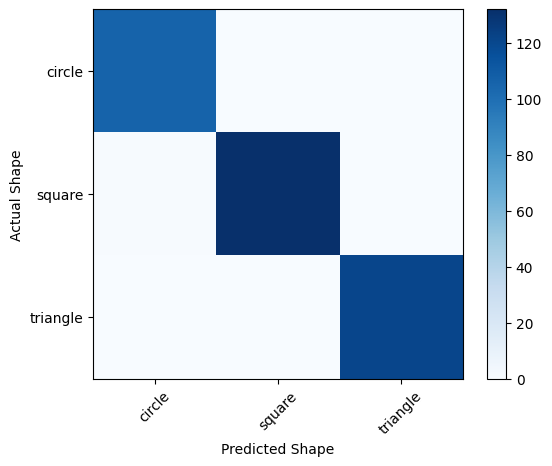

[[106   0   0]
 [  1 132   0]
 [  0   0 121]]


In [29]:
# Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()
print(cm)

## Save the Trained model

Now that you've trained a working model, you can save it (including the trained weights) for use later.

In [13]:
# Save the model weights
model_file = 'models/shape_classifier.pt'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

model saved as models/shape_classifier.pt


## Use the trained model

Now that we've trained and evaluated our model, we can use it to predict classes for new images.

NameError: name 'Net' is not defined

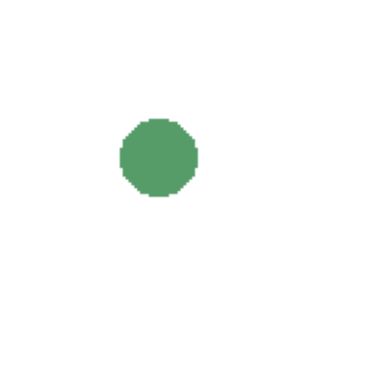

In [ ]:
import matplotlib.pyplot as plt
import os
from random import randint
%matplotlib inline


# Function to predict the class of an image
def predict_image(classifier, image):
    import numpy
    
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all inputs as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input_features)
    index = output.data.numpy().argmax()
    return index


# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return np.array(img)

# Create a random test image
classnames = os.listdir(os.path.join('data', 'shapes'))
classnames.sort()
shape = classnames[randint(0, len(classnames)-1)]
img = create_image ((128,128), shape)

# Display the image
plt.axis('off')
plt.imshow(img)

# Create a new model class and load the saved weights
model = Net()
model.load_state_dict(torch.load(model_file))

# Call the predction function
index = predict_image(model, img)
print(index)
print(classes[index])

## Further Reading

To learn more about training convolutional neural networks with PyTorch, see the [PyTorch documentation](https://pytorch.org/).

## Challenge: Safari Image Classification

Hopefully this notebook has shown you the main steps in training and evaluating a CNN. Why not put what you've learned into practice with our Safari image classification challenge in the [/challenges/05 - Safari CNN Challenge.ipynb](./challenges/05%20-%20Safari%20CNN%20Challenge.ipynb) notebook?

> **Note**: The time to complete this optional challenge is not included in the estimated time for this exercise - you can spend as little or as much time on it as you like!